## Manhattan plot for trans-eQTLs

Initial look at the trans-eQTLs, and get some basic plots:
 - Manhattan plot
 - Q-Q plot
 
Define the input directories and variables here:

In [3]:
resdir = "/usr/users/sbanerj/trans_eqtl_results/gtex_v8_pub"
#resdir = "/scratch/sbanerj/trans-eqtl/dev-pipeline/gtex_v8"
tissuelist = ["as"]
tejaas_preproc = "raw_std"
tejaas_method_variant = "permnull_sb0.1_knn"
rrfile = "rr.txt"
#chrmlist = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
chrmlist = [19, 20, 21, 22]

In [4]:
import numpy as np
import pygtrie
from statsmodels.stats import multitest
import collections
import os

import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib
import sys
sys.path.append('../')
from utils import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 24, colors = 'banskt', dpi = 72)

In [5]:
def read_tejaas(filename):
    rsidlist = list()
    bplist   = list()
    pvallist = list()
    with open(filename, 'r') as instream:
        next(instream)
        for line in instream:
            linesplit = line.strip().split()
            rsid = linesplit[0]
            bppos = int(linesplit[1])
            pval = float(linesplit[5])
            rsidlist.append(rsid)
            bplist.append(bppos)
            pvallist.append(pval)
    return rsidlist, pvallist, bplist

def read_tejaas_all_chrom(filefmt, chrmlist):
    gwrsids = list()
    gwpvals = list()
    gwnsnps = dict()
    gwbppos = dict()
    
    for chrm in chrmlist:
        filepath = filefmt.format(chrm)
        rsids, pvals, bplist = read_tejaas(filepath)
        gwrsids += rsids
        gwpvals += pvals
        gwnsnps[chrm] = len(rsids)
        gwbppos[chrm] = np.array(bplist)
        
    gwpvals = np.array(gwpvals)
    
    ## Sanity check of p-value
    # Are there any nan p-values?
    nan_mask = np.isnan(gwpvals)
    if np.any(nan_mask):
        print(f'SNPs with nan p-value: {np.sum(nan_mask)}')
        gwpvals[np.where(nan_mask)[0]] = 1.0 ## just ignore this SNP
        
    # Are there any zero p-values
    zero_mask = gwpvals == 0
    if np.any(zero_mask):
        print(f'SNPs with zero p-value: {np.sum(zero_mask)}')
        gwpvals[np.where(zero_mask)[0]] = np.min(gwpvals[~zero_mask])    
    
    return gwrsids, gwnsnps, gwbppos, gwpvals

In [6]:
def plot_manhattan(ax, chrmlist, nsnps, bppos, log10pvals, log10cutoff):
    
    i = 0
    start = 0
    lastbp = 0
    xtickposlist = list()
    
    for chrm in chrmlist:
        end = start + nsnps[chrm]
        chrm_bppos = bppos[chrm]
        xtickposlist.append(lastbp + int((chrm_bppos[0] + chrm_bppos[-1]) / 2))

        y = log10pvals[start:end]
        nchoose = np.where(y >= log10cutoff)
        x = lastbp + chrm_bppos[nchoose]
        ax.scatter(x, y[nchoose], alpha = 1.0, s = 6)
        nchoose = np.where(y < log10cutoff)
        nchoose_sparse = np.sort(np.random.choice(nchoose[0], int(nchoose[0].shape[0] / 20), replace=False))
        x = lastbp + chrm_bppos[nchoose_sparse]
        ax.scatter(x, y[nchoose_sparse], color='gainsboro', s = 6, alpha = 0.8)
        
        start = end
        lastbp += chrm_bppos[-1]
        
    ax.set_xlim(0, lastbp)
    ax.plot([0, lastbp], [log10cutoff, log10cutoff], ls = 'dashed', color='gainsboro')
    ax.set_xticks(xtickposlist)
    ax.set_xticklabels(["{:d}".format(x) for x in chrmlist])
    
    return

#### Load results for TEJAAS

In [8]:
filefmt = f'{resdir}/{tissuelist[0]}/tejaas/{tejaas_preproc}/{tejaas_method_variant}/chr' + "{:d}" + f'/{rrfile}'
gwrsids, gwnsnps, gwbppos, gwpvals = read_tejaas_all_chrom(filefmt, chrmlist)
gwlog10pvals = -np.log10(gwpvals)

SNPs with zero p-value: 82


#### Check the p-value distribution

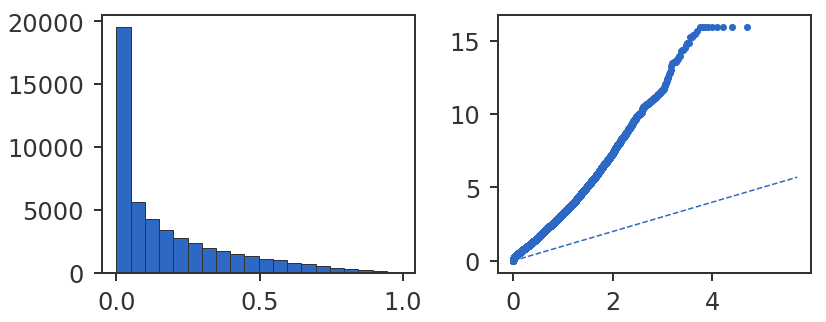

In [9]:
def simpleQQplot(ax, pvals, sample_size):
    N = len(pvals)
    y = -np.log10(np.sort(pvals[np.random.choice(N, size = sample_size, replace = False)]))
    x = -np.log10(np.arange(1, sample_size + 1) / sample_size)
    maxval = x[0] + 1
    ax.scatter(x, y)
    ax.plot([0, maxval], [0, maxval], ls = 'dashed')

fig = plt.figure(figsize = (12, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

nplotsnp = min(50000, gwpvals.shape[0])
nchoose = np.sort(np.random.choice(gwpvals.shape[0], size = nplotsnp, replace = False))
ax1.hist(gwpvals[nchoose])
simpleQQplot(ax2, gwpvals, nplotsnp)

plt.tight_layout()
plt.show()

#### Manhattan Plot

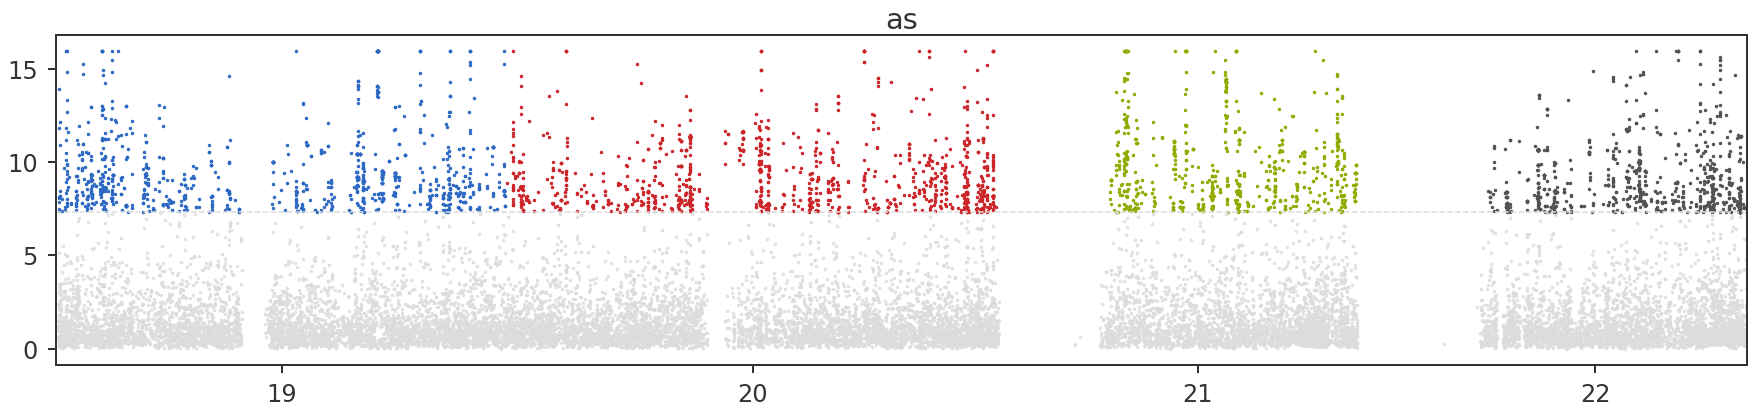

In [12]:
fig = plt.figure(figsize = (25, 6))
ax1 = fig.add_subplot(111)

log10cutoff = -np.log10(5e-8)

plot_manhattan(ax1, chrmlist, gwnsnps, gwbppos, gwlog10pvals, log10cutoff)

plt.tight_layout()

ax1.set_title(tissuelist[0])
outfile = f'../plots/manhattan_{tissuelist[0]}_19-22_pub.png'
plt.savefig(outfile, bbox_inches='tight')

plt.show()